<a href="https://colab.research.google.com/github/sravanisasu/Happy_monk/blob/main/Happymonk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries**

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import minmax_scale
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

**Extract Iris dataset and apply minmax scaler**

In [ ]:
data = datasets.load_iris()
x = data.data
y = data.target
x = minmax_scale(x)
y = minmax_scale(y)

**Convert output to one hot encoding using dummies**

In [ ]:
new_y = np.array(pd.get_dummies(y))

**Split the data set to train and test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, new_y, test_size=0.2, random_state=42)

**Define custom model as per the requirement**

In [ ]:
class custom_model(Model):
    def __init__(self):
      super(custom_model, self).__init__()
      self.L1 = Dense(10,use_bias=True,trainable=True)
      self.L2 = Dense(5,use_bias=True,trainable=True)
      self.L3 = Dense(3,use_bias=True,trainable=True)
      self.k0 = tf.Variable(np.random.rand(1),trainable=True,dtype='float32')
      self.k1 = tf.Variable(np.random.rand(1),trainable=True,dtype='float32')

    def call(self, inputs,training=True):
      a0 = self.k0 + ( self.k1 * inputs )
      z1 = self.L1(a0)
      a1 = self.k0 + ( self.k1 * z1 )
      z2 = self.L2(a1)
      a2 = self.k0 + ( self.k1 * z2 )
      z3 = self.L3(a2)
      a3 = tf.nn.softmax(z3)
      return a3

**Initalise the model, loss function, optimiser and required metric**

In [ ]:
model = custom_model()
opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

#store intial k0 and k1 values
k0_list=[model.get_weights()[-2]]
k1_list=[model.get_weights()[-1]]

**Train model and create callback**

In [ ]:
#intialise callback for weights monitoring
weights_dict = {}
weight_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch
    , logs: weights_dict.update({epoch:model.get_weights()})
    )

history = model.fit( x_train, y_train, epochs=20, verbose=1,callbacks=weight_callback )

#store all k0 and k1 values for each epoch
for epoch,weights in weights_dict.items():
  k0_list.append(weights[-2])
  k1_list.append(weights[-1])

Epoch 1/20
4/4 [==============================] - 14s 4ms/step - loss: 1.2165 - accuracy: 0.3344
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.1067 - accuracy: 0.3462
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0561 - accuracy: 0.3377
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0144 - accuracy: 0.2871
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9448 - accuracy: 0.6044
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8615 - accuracy: 0.6679
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7682 - accuracy: 0.6177
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6679
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5420 - accuracy: 0.6721
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4364 - accuracy: 0.7319
Epoch 11/20
4/4 [=====================

**Plot the k0 and k1 values**

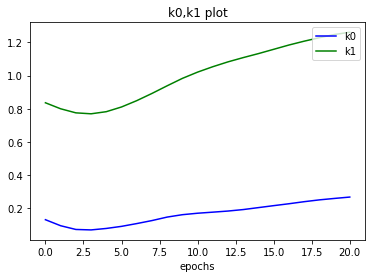

Intial k0 value  [0.12984607]  k1 value  [0.83582664]
Final k0 value  [0.2665351]  k1 value  [1.2616541]


In [ ]:
epoch_list = range(0,21)
plt.plot(epoch_list, k0_list, '-b', label='k0')
plt.plot(epoch_list, k1_list, '-g', label='k1')
plt.xlabel("epochs")
plt.legend(loc='upper right')
plt.title("k0,k1 plot")
plt.show()
print("Intial k0 value ",k0_list[0]," k1 value ",k1_list[0])
print("Final k0 value ",k0_list[-1]," k1 value ",k1_list[-1])

**Plot the loss and accuracy for the training**

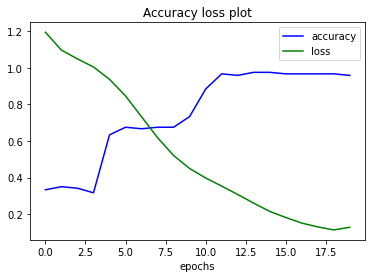

In [ ]:
epoch_list = range(0,20)
plt.plot(epoch_list, history.history['accuracy'], '-b', label='accuracy')
plt.plot(epoch_list, history.history['loss'], '-g', label='loss')
plt.xlabel("epochs")
plt.legend(loc='upper right')
plt.title("Accuracy loss plot")
plt.show()

**Print train and test loss and accuracy**

In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

stats={'Training Loss':train_loss,'Training Acc':train_acc,'Test loss':test_loss,'Test Acc':test_acc}
for key in stats:
  print(key,"-->",stats[key])

Training Loss --> 0.09257780015468597
Training Acc --> 0.9666666388511658
Test loss --> 0.13151516020298004
Test Acc --> 0.9666666388511658


**Calculate f1 score using TP,TN,FP,FN**

In [ ]:
y_true = y_test

output = model.predict(x_test)
y_pred = (output == output.max(axis=1)[:,None]).astype(int)

#True positive 1*1
TP = tf.math.count_nonzero(y_pred * y_true)
#True negative (0-1)*(0-1)
TN = tf.math.count_nonzero((y_pred - 1) * (y_true - 1))
#false positive (1)*(0-1)
FP = tf.math.count_nonzero(y_pred * (y_true - 1))
#false negative (0-1)*(1)
FN = tf.math.count_nonzero((y_pred - 1) * y_true)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print("F1 score - ",f1.numpy())

F1 score -  0.9666666666666667
